# Train Noisy Circle Detector
(This notebook is a good example of a standalone notebook that was run on GPU cloud instance for fast training.
The cells record the cloud output. The finished notebook and best epoch files were then downloaded locally. 
Explanations were then added to the markdown cells for clarification.)

## In this notebook:
* You'll create data from scratch
    * Use a data generator to create and train on more data than can fit in memory
* Define a medium sized 2 dimensional convnet
* Train the model to:
    * detect a class of a shape, randomly located in an image
    * detect the image regardless of noisy and incomplete data
    * perform a regression to three values:
        * the pixel row where the shape's bounding box starts
        * the pixel column where the shape's bounding box starts
        * the value of the radius of the circle shape contained inside the bounding box
        
### Why?
Most computer vision examples and practical implementations leverage transfer learning and use a baseline image detection model and then just train off of that. While this is helpful and generally recommended, it does present challenges, pretrained image models are often:
    * large
    * complex
    * difficult to tune
    * may unnecessary features 
        * e.g. many bounding boxes, many shapes
    
Using a smaller, custom made model should be easier:
* to explore and visualize activations
* adjust and tune model parameters
* vet improvements to model design that may be applicable to larger models

### Baseline library installations for this notebook

In [1]:
#! pip install keras matplotlib scikit-image numpy Shapely==1.6.4.post2 Pillow opencv-python tqdm

In [2]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import numpy as np
# For some reason, this import works locally but complains in GCP,
# from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import gc
import os
import sys
import random
import math
import re
import time
import cv2
import matplotlib
# Root directory of the project
ROOT_DIR = os.path.abspath(".") 
sys.path.append(ROOT_DIR)  # To find local version of the library
from PIL import Image

from keras.utils import Sequence  
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling2D, Flatten, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

## Some utility functions for creating and randomizing our data

In [4]:
def draw_circle(img, row, col, rad):
    """Draw a circle into a matrix."""
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]

def noisy_circle(size, radius, noise):
    """Generate a random circle for an image, and add noise."""
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Add noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

def find_circle(img):
    """
    Find the circle in the noisy image.
    param: img: a 200x200 pixel image
    returns: tuple of row, col, radius.
    """
    try:
        global the_model
        if not the_model:
            the_model = get_model()
        # normalize the data for the model
        image = (img - np.mean(img)) / np.std(img)
        results = the_model.predict(image.reshape(1, 200, 200, 1))
        row, col, rad = results[0]
        return (round(row), round(col), round(rad))
    except Exception as ex:
        print(ex) # log failure here
        print("fail!")
        return 100, 100, 30

def iou(ytrue, ypred):
    """
    Determine intersection over union percentage. 
    Area of intersection divided by area of union
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    row0, col0, rad0 = ytrue 
    row1, col1, rad1 = ypred 
    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)
    return (shape0.intersection(shape1).area /
        shape0.union(shape1).area)

## Let's view an example of what we're searching for and the surrounding data

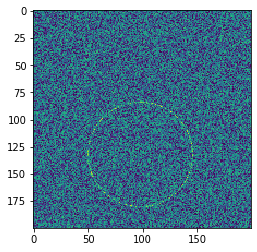

In [5]:
def show_image(an_image):
    # convert values to 0 - 255 int8 format
    formatted = (an_image * 255 / np.max(an_image)).astype('uint8')
    img = Image.fromarray(formatted)
    imshow(np.asarray(img))

params, an_image = noisy_circle(200, 50, 2)    
show_image(an_image)

# Generate validation set data

In [6]:
num_imgs = 8000
img_size = 200

# set with zeros, but don't worry as they will be overwritten with noise
y_validation = np.zeros((num_imgs, 3), dtype=np.float32)  
imgs = np.zeros((num_imgs, img_size, img_size), dtype=np.float32)  

for i_img in  range(num_imgs):
    params, img = noisy_circle(200, 50, 2)
    row, col, rad = params
    imgs[i_img] = img  
    y_validation[i_img] = [row, col, rad ]        
print(imgs.shape, y_validation.shape)

# Reshape and normalize the image data to mean 0 and std 1.

img_data = (imgs  - np.mean(imgs)) / np.std(imgs)
X_validation = img_data.reshape(img_data.shape[0], 200, 200 , 1).astype(np.float32)
print(X_validation.shape, np.mean(X_validation), np.std(X_validation))

## Delete unused data/helper objects so the training system isn't uncessarily burdened

del img_data 
del imgs
gc.collect()

(8000, 200, 200) (8000, 3)
(8000, 200, 200, 1) 3.7310604e-06 0.99999917


2360

## Define Callbacks for checkpoint saving and reducing the learning rate on plateau

In [7]:
filepath="noisy.circle.detector.best.epoch{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mse', #'val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_mse', #'val_mean_squared_error', # val_loss
                                        factor=0.1, patience=10,
                                        verbose=1, mode='auto',
                                        min_delta=0.0001, cooldown=0, min_lr=0)

# Note: specifying via: val_mean_squared_error worked on tf 1.14, looks like a change for 2.0

def step_decay(epoch):
    """learning rate schedule"""
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# learning schedule callback
lrate = LearningRateScheduler(step_decay)

callbacks_list = [checkpoint, reduce_lr_on_plateau] # , lrate]

# Define and build the model
## Note 
* We don't use stride, since that may lose some object edge information which is useful for detecting the boundaries

In [8]:
pool_size = 2
chanDim = -1
the_input_shape =(200, 200, 1)
# This model def yielded 0.917 items greater or equal to .7 IOU 

model = Sequential(name='Noisy Circle Detector')
model.add(Conv2D(32, (3, 3),
                input_shape=the_input_shape,
                activation="relu",
                padding="same",
                name="Conv2dLayer1"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization1"))      
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer1'))  
model.add(Conv2D(64, (3, 3),
                activation="relu",
                padding="same",
                name="Conv2dLayer2"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization2"))                
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer2'))  
model.add(Conv2D(128, (3, 3),
                activation="relu",
                padding="same",
                name="Conv2dLayer3"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization3"))                
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer3'))  
model.add(Conv2D(128, (3, 3),
                activation="relu",
                padding="same",
                name="Conv2dLayer4"))
model.add(BatchNormalization(axis=chanDim, name="BatchNormalization4"))                
model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPoolingLayer4'))  
model.add(Flatten(name='FlattenLayer1'))
model.add(Dense(128, activation='relu', name='DenseLayer1')) # was 256 yielded .897
model.add(Dense(3, activation='linear', name='DenseLayer2'))
model.compile(loss='mse',
              optimizer=RMSprop(lr=1e-2),
              metrics=['mae', 'mse'])
model.summary()


Model: "Noisy Circle Detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2dLayer1 (Conv2D)        (None, 200, 200, 32)      320       
_________________________________________________________________
BatchNormalization1 (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
MaxPoolingLayer1 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
Conv2dLayer2 (Conv2D)        (None, 100, 100, 64)      18496     
_________________________________________________________________
BatchNormalization2 (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
MaxPoolingLayer2 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
Conv2dLayer3 (Conv2D)        (None, 50, 50, 

## Create our Sequence Generator for training data
this allows us to train on many more random samples than would fit into memory

In [9]:
class NoisyCircleGenerator(Sequence):
    def __init__(self, batch_size=64, total_images=1000, steps_per_epoch=15):
        self.batch_size = batch_size
        self.total_images = total_images
        self.shuffle =False
        self.steps_per_epoch=steps_per_epoch
        
        
    def __len__(self):
        return int(np.floor(self.total_images / self.batch_size))
          
    def __getitem__(self, index):       
        num_imgs = self.batch_size
        img_size = 200
        # set with zeros, but don't worry as they will be overwritten with noise
        y = np.zeros((num_imgs, 3), dtype=np.float32)  
        imgs = np.zeros((num_imgs, img_size, img_size), dtype=np.float32)  
        for i_img in  range(num_imgs):
            params, img = noisy_circle(200, 50, 2)
            row, col, rad = params
            imgs[i_img] = img  
            y[i_img] = [row, col, rad ]        
        img_data = (imgs  - np.mean(imgs)) / np.std(imgs)
        del imgs
        X = img_data.reshape( num_imgs , 200, 200 , 1).astype(np.float32)
        del img_data
        return X, y

    def on_epoch_end(self):
        pass

##  Define our dataset and batch sizes

In [10]:
num_images = 80000
batch_size=64
steps_req = int(num_images// batch_size)
train_gen = NoisyCircleGenerator(total_images= num_images, steps_per_epoch=steps_req)

## Train the model, record callback history

In [11]:
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=steps_req,
                              epochs=40,
                              validation_data=(X_validation, y_validation),
                              use_multiprocessing=True,
                              workers=4 ,
                              callbacks=callbacks_list)


Epoch 1/40
1250/1250 [==============================] - 90s 72ms/step - loss: 2433.2083 - mae: 12.2244 - mse: 2433.2029 - val_loss: 193.3253 - val_mae: 11.1247 - val_mse: 193.3253

Epoch 00001: val_mse improved from inf to 193.32532, saving model to noisy.circle.detector.best.epoch01.hdf5
Epoch 2/40
1250/1250 [==============================] - 89s 71ms/step - loss: 64.0805 - mae: 5.8435 - mse: 64.0806 - val_loss: 2490.3341 - val_mae: 39.4765 - val_mse: 2490.3337

Epoch 00002: val_mse did not improve from 193.32532
Epoch 3/40
1250/1250 [==============================] - 89s 71ms/step - loss: 45.9657 - mae: 4.8786 - mse: 45.9657 - val_loss: 31.6135 - val_mae: 4.0972 - val_mse: 31.6135

Epoch 00003: val_mse improved from 193.32532 to 31.61349, saving model to noisy.circle.detector.best.epoch03.hdf5
Epoch 4/40
1250/1250 [==============================] - 88s 71ms/step - loss: 33.7636 - mae: 4.0889 - mse: 33.7636 - val_loss: 144.5076 - val_mae: 9.6297 - val_mse: 144.5077

Epoch 00004: val_

In [12]:
# Often at the end of training we save the final model, but the last checkpoint provides our best model yet
# model.save('noisy.circle.detector.last.hdf5')

## Plot validation accuracy and loss

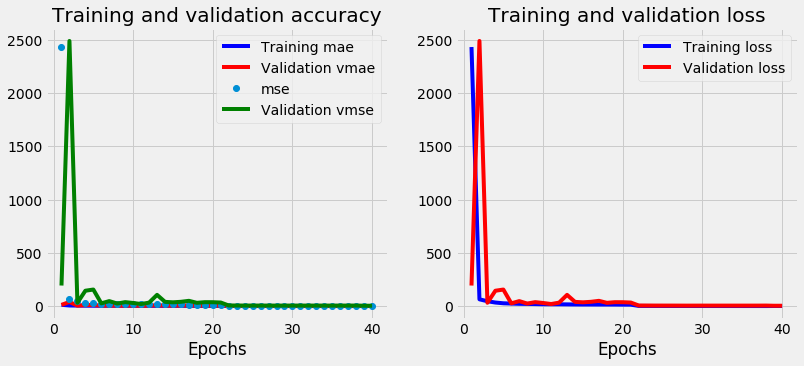

In [13]:
plt.style.use('fivethirtyeight')

def plot_history(history):
    mae = history.history['mae'] # 'mean_absolute_error']
    mse = history.history['mse'] # 'mean_squared_error']
    vmae = history.history['val_mae'] #'val_mean_absolute_error']
    vmse = history.history['val_mse'] # #'val_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mae) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mae, 'b', label='Training mae')
    plt.plot(x, vmae, 'r', label='Validation vmae')
    plt.plot(x, mse, 'o', label='mse')
    plt.plot(x, vmse, 'g', label='Validation vmse')    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_history(history)

### To assess the model performance see the other notebook assess_noisy_circle_detector.ipynb